In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
%cd /content/drive/MyDrive/Colab Notebooks/Neural Networks
! ls

/content/drive/MyDrive/Colab Notebooks/Neural Networks
 a1_IMDB_Dataset.csv	      c1_lstm_model_acc_0.864.h5
 a2_glove.6B.100d.txt	     'Processing Image Data for Deep Learning.ipynb'
 a3_IMDb_Unseen_Reviews.csv


In [30]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

**Loading Dataset**

In [31]:
# Importing IMDb Movie Reviews dataset
movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")

In [32]:
movie_reviews.shape

(50000, 2)

In [33]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [34]:
# Checking for missing values Skewness
movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

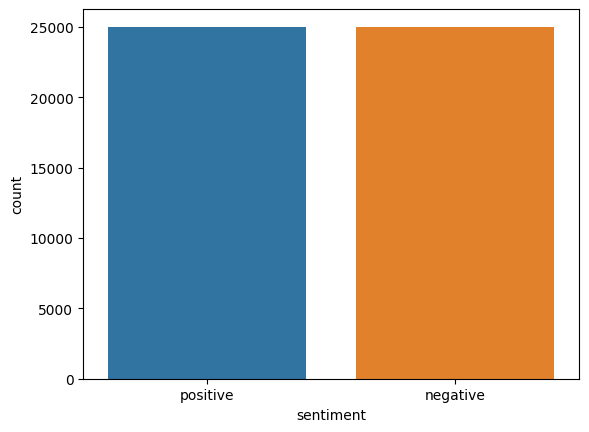

In [35]:
#Visualize the distribution
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

**Data Preprocessing**

In [36]:


movie_reviews["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [37]:

# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [38]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [40]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [41]:
# Sample cleaned up movie review

X[1]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating every surface terribly well done '

In [42]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

**Preparing embedding layer**

In [44]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [45]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [46]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [47]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [49]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [50]:
embedding_matrix.shape

(92394, 100)

**Model Training with**

**Simple Neural Network**

In [51]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [52]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9,249,401
Trainable params: 10,001
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [53]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 3s 8ms/step - loss: 0.5615 - acc: 0.7101 - val_loss: 0.5018 - val_acc: 0.7588
Epoch 2/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4501 - acc: 0.7952 - val_loss: 0.4951 - val_acc: 0.7666
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4117 - acc: 0.8168 - val_loss: 0.5042 - val_acc: 0.7632
Epoch 4/6
250/250 [==============================] - 1s 6ms/step - loss: 0.3905 - acc: 0.8264 - val_loss: 0.5091 - val_acc: 0.7630
Epoch 5/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3755 - acc: 0.8360 - val_loss: 0.5245 - val_acc: 0.7576
Epoch 6/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3635 - acc: 0.8433 - val_loss: 0.5329 - val_acc: 0.7577


In [55]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5611 - acc: 0.7486


In [56]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5611394643783569
Test Accuracy: 0.7486000061035156


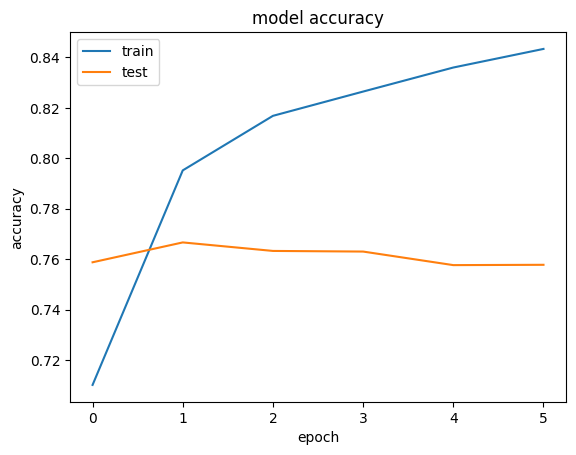

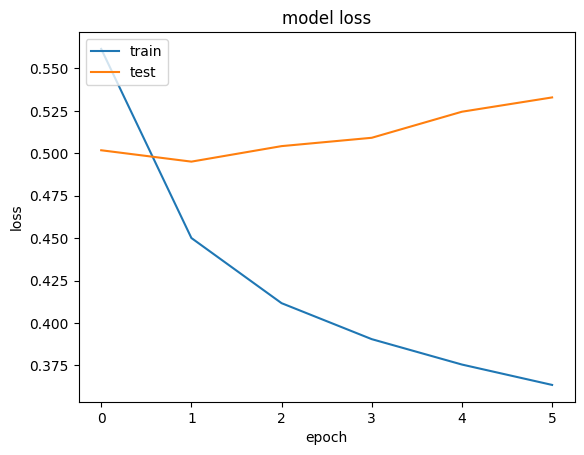

In [57]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

**Convolutional Neural Network**

In [58]:
from keras.layers import Conv1D

In [59]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [60]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,303,657
Trainable params: 64,257
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [61]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 31s 119ms/step - loss: 0.4686 - acc: 0.7750 - val_loss: 0.4045 - val_acc: 0.8170
Epoch 2/6
250/250 [==============================] - 37s 148ms/step - loss: 0.3377 - acc: 0.8570 - val_loss: 0.3552 - val_acc: 0.8435
Epoch 3/6
250/250 [==============================] - 31s 124ms/step - loss: 0.2839 - acc: 0.8874 - val_loss: 0.3414 - val_acc: 0.8510
Epoch 4/6
250/250 [==============================] - 33s 134ms/step - loss: 0.2386 - acc: 0.9117 - val_loss: 0.3495 - val_acc: 0.8494
Epoch 5/6
250/250 [==============================] - 43s 171ms/step - loss: 0.2019 - acc: 0.9302 - val_loss: 0.3306 - val_acc: 0.8574
Epoch 6/6
250/250 [==============================] - 32s 128ms/step - loss: 0.1631 - acc: 0.9509 - val_loss: 0.3333 - val_acc: 0.8565


In [62]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 3s 11ms/step - loss: 0.3354 - acc: 0.8545


In [63]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.33543986082077026
Test Accuracy: 0.8544999957084656


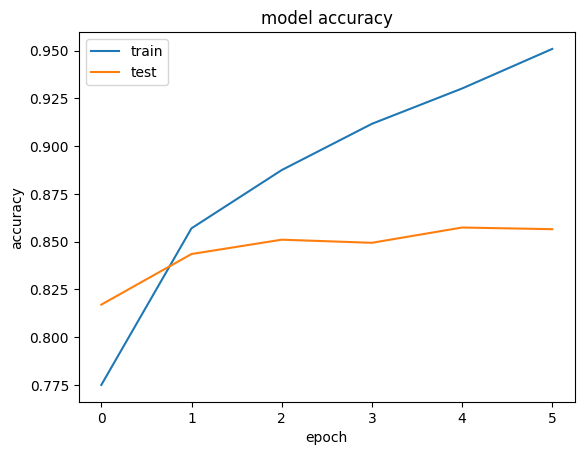

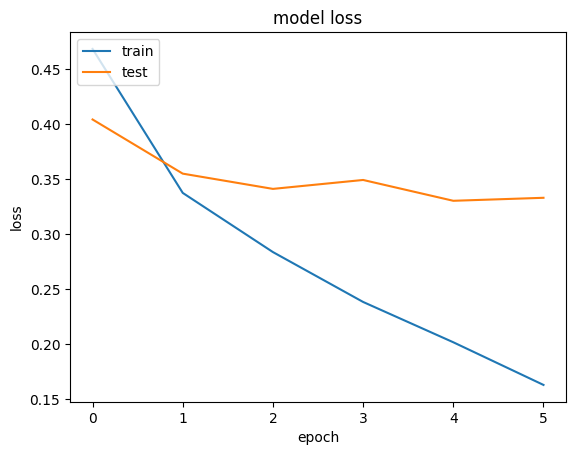

In [64]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

**Recurrent Neural Network (LSTM)**

In [65]:
from keras.layers import LSTM

In [66]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [67]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [68]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 117s 459ms/step - loss: 0.5013 - acc: 0.7554 - val_loss: 0.4166 - val_acc: 0.8170
Epoch 2/6
250/250 [==============================] - 96s 385ms/step - loss: 0.4149 - acc: 0.8111 - val_loss: 0.3821 - val_acc: 0.8311
Epoch 3/6
250/250 [==============================] - 89s 357ms/step - loss: 0.3810 - acc: 0.8340 - val_loss: 0.3491 - val_acc: 0.8495
Epoch 4/6
250/250 [==============================] - 91s 366ms/step - loss: 0.3534 - acc: 0.8498 - val_loss: 0.3303 - val_acc: 0.8576
Epoch 5/6
250/250 [==============================] - 93s 373ms/step - loss: 0.3241 - acc: 0.8623 - val_loss: 0.3310 - val_acc: 0.8622
Epoch 6/6
250/250 [==============================] - 95s 379ms/step - loss: 0.3060 - acc: 0.8736 - val_loss: 0.3240 - val_acc: 0.8604


In [69]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 19s 62ms/step - loss: 0.3295 - acc: 0.8603


In [70]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.32948601245880127
Test Accuracy: 0.8603000044822693


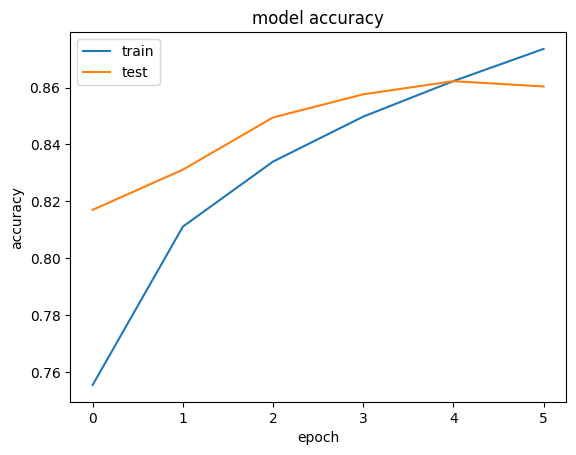

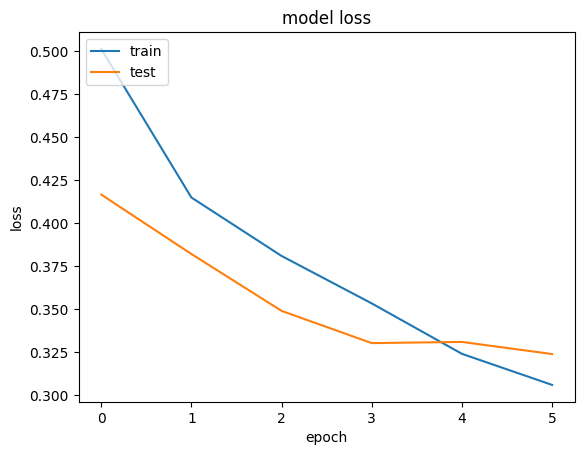

In [71]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [72]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

**Making Predictions on Live IMDb data**

In [73]:
!ls # lists files in working directory

 a1_IMDB_Dataset.csv	      c1_lstm_model_acc_0.864.h5
 a2_glove.6B.100d.txt	      c1_lstm_model_acc_0.86.h5
 a3_IMDb_Unseen_Reviews.csv  'Processing Image Data for Deep Learning.ipynb'


In [74]:
# # Load previously trained LSTM Model

# from keras.models import load_model

# model_path ='./c1_lstm_model_acc_0.856.h5'
# pretrained_lstm_model = load_model(model_path)

# # summarize model.
# pretrained_lstm_model.summary()
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [75]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [76]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [77]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 576ms/step


array([[0.91249704],
       [0.98914796],
       [0.19859667],
       [0.7536695 ],
       [0.96821004],
       [0.0185903 ]], dtype=float32)

In [78]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.1
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,2.0
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,7.5
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.7
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.2
